<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/video_notebooks/06_pytorch_transfer_learning_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning

Transfer learning is the art of taking a pretrained model and applying it to your own problem.

* Ground truth notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/06_pytorch_transfer_learning.ipynb 
* https://www.learnpytorch.io/06_pytorch_transfer_learning/ 


In past sections, we've written plenty of helpful code and we'd like to get that into this notebook...
* Code link: https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular/going_modular

## 0. Getting setup

Going to import helpful code from previous sections.

And setup a GPU... so we can use device agnostic code.\

We also want to get `torchinfo` - https://github.com/TylerYep/torchinfo 

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt 

from torch import nn
from torchvision import transforms, datasets, models

# Try to get torchinfo, if it doesn't work, download it
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

# Try to get going_modular directory, if we can't get it, donwload it
try:
  from going_modular.going_modular import data_setup, engine
except:
  # Get the going_modular scripts from GitHub
  print("[INFO] Couldn't find going_modular scripts... downloading them.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 1751, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 1751 (delta 94), reused 189 (delta 83), pack-reused 1548
Receiving objects: 100% (1751/1751), 232.81 MiB | 29.95 MiB/s, done.
Resolving deltas: 100% (954/954), done.


In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

We want our pizza, steak, sushi dataset we've been using previously.

The data is here: https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip 

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, let's download it
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping download.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi images from GitHub
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Download pizza, steak, sushi data...")
    f.write(request.content)
  
  # Unzip the data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)
  
  # Remove the .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Download pizza, steak, sushi data...
Unzipping pizza, steak, sushi data...


## 2. Create DataLoaders from data

Transfer learning = get a pretrained model and adapt it to your own problem (so it can fit on your data).

When using **transfer learning**, it's important to format your data in the same way the pretrained model was trained in.

Because we're using `torchvision.models`, we have to prepare our data in the same way those models were trained - https://pytorch.org/vision/stable/models.html 

From the documentation:

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 

In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [5]:
from torchvision import transforms
from going_modular.going_modular import data_setup

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


simple_transform = transforms.Compose([
  transforms.Resize((224, 224)), # resize to 224, 224 
  transforms.ToTensor(), # turn into range [0, 1]
  normalize # make sure images have the right mean and standard deviation
])


train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fcefbc6d950>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

Which model should you choose?

* If you need fast performance (you have limited compute, e.g. a mobile device), a smaller model is often better.
* If you have unlimited compute, go for the biggest model you can.

See here for more information on model choice: https://www.learnpytorch.io/06_pytorch_transfer_learning/#31-which-pretrained-model-should-you-use 

More pretrained PyTorch models here: https://pytorch.org/vision/stable/models.html 

In [6]:
from torchvision import models

model = models.efficientnet_b0(pretrained=True).to(device)
# model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

### Getting information about our model

In [7]:
# Print a summary using torchinfo 
from torchinfo import summary
summary(model=model,
        input_size=(32, 3, 224, 224), # example of what shape data you'd like to put into your model
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─ConvNormActivation (0)                                [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [9]:
from going_modular.going_modular import model_builder

summary(model_builder.TinyVGG(input_shape=3,
                              hidden_units=10,
                              output_shape=3),
        input_size=(32, 3, 64, 64),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
TinyVGG (TinyVGG)                        [32, 3, 64, 64]      [32, 3]              --                   True
├─Sequential (conv_block_1)              [32, 3, 64, 64]      [32, 10, 30, 30]     --                   True
│    └─Conv2d (0)                        [32, 3, 64, 64]      [32, 10, 62, 62]     280                  True
│    └─ReLU (1)                          [32, 10, 62, 62]     [32, 10, 62, 62]     --                   --
│    └─Conv2d (2)                        [32, 10, 62, 62]     [32, 10, 60, 60]     910                  True
│    └─ReLU (3)                          [32, 10, 60, 60]     [32, 10, 60, 60]     --                   --
│    └─MaxPool2d (4)                     [32, 10, 60, 60]     [32, 10, 30, 30]     --                   --
├─Sequential (conv_block_2)              [32, 10, 30, 30]     [32, 10, 13, 13]     --                   True
│    └─Conv2d (0)   

### Freezing our model's base layers and updating the classifier head (output layer)

In [10]:
# Freeze all the base layers
for param in model.features.parameters():
  param.requires_grad = False 

In [11]:
# Change the classifier layer to suit our problem 

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the required output shape
output_shape = len(class_names)

# Recreate the classifier layer and send it to the target device
from torch import nn
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=output_shape, bias=True)
).to(device) 

In [12]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [13]:
summary(model=model,
        input_size=(32, 3, 224, 224), # example of what shape data you'd like to put into your model
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─ConvNormActivation (0)                                [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train model

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Write training code
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training
from going_modular.going_modular import engine
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took 
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0894 | train_acc: 0.4492 | test_loss: 0.9214 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8697 | train_acc: 0.7734 | test_loss: 0.8036 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7769 | train_acc: 0.7734 | test_loss: 0.7404 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7244 | train_acc: 0.7422 | test_loss: 0.6488 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6426 | train_acc: 0.7812 | test_loss: 0.6254 | test_acc: 0.8968
[INFO] Total training time: 10.732 seconds


## 5. Evaluate model by plotting loss curves

In [16]:
# Get the plot_loss_curves() from a previous noteboook (can do this by downloading helper_functions.py)
try:
  from helper_functions import plot_loss_curves
except:
  print("[INFO] Couldn't find helper_functions.py, downloading...")
  with open("helper_functions.py", "wb") as f:
    import requests 
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

[INFO] Couldn't find helper_functions.py, downloading...


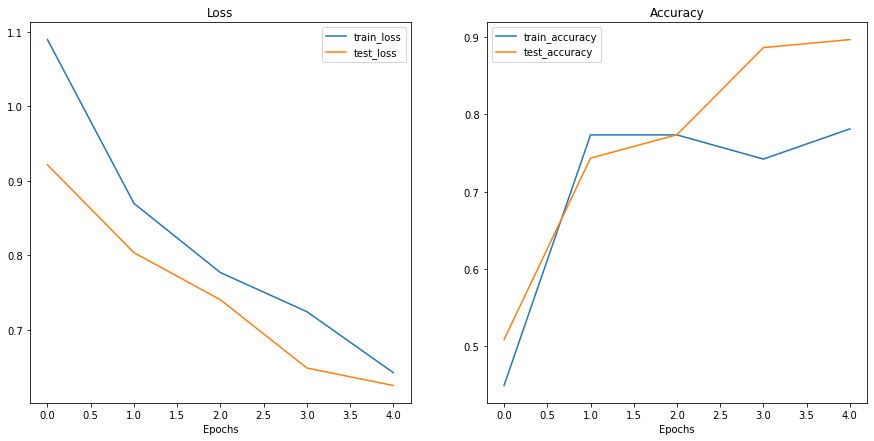

In [17]:
# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Make predictions on images from the test set

Before we make predictions on data the model has never seen before, we have to format it in the same way the data our model was trained on was formatted.

Namely:
1. *Same shape* - our custom data should be in the same shape as the data our model was trained on.
2. *Same datatype* - was our data normalized or transformed in a certain way? If so, we should do the same to the unseen data?
3. *Same device* - what device are we using for inference?


In [19]:
from PIL import Image
from typing import List, Tuple

def pred_and_plot_image(model: torch.nn.Module,
                        class_names: List[str],
                        image_path: str,
                        image_size: Tuple[int, int]=(224, 224), # default size for EffNetB0
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
  # Open image
  img = Image.open(image_path)
  
  # Create transformatin for image (if on doesn't exist)
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
                                          transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225])                                    
    ])

  ### Predict on image ###

  # Make sure model is on the target device
  model.to(device) 

  # Turn on model eval mode and inference mode
  model.eval()
  with torch.inference_mode():
    # Transform image and add extra dimension to make sure our image has a batch dimension
    transformed_image = image_transform(img).unsqueeze(dim=0) # [C, H, W] -> [N, C, H, W]

    # Make a prediction on image with an extra dimension and make sure the image is on the target device
    target_image_pred = model(transformed_image.to(device))
  
  # Convert logits -> predictions probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert pred probs -> pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image with predicted label and probability
  plt.figure()
  plt.imshow(img) # using untransfromed image
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);

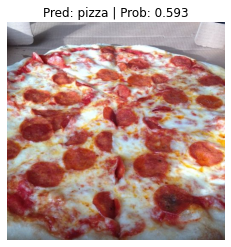

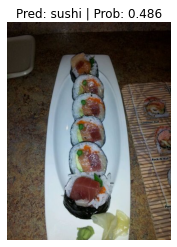

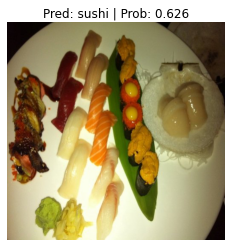

In [34]:
# Get all of the path names from the test
import random
from pathlib import Path
# random.seed(42)
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))

### 6.1 Predict on a custom image

Want to make a predicton on a custom from the internet, namely: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg 

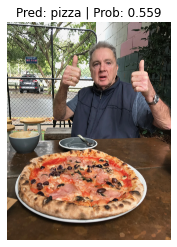

In [37]:
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download.")

# predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

## Exercises and Extra-curriculum

See exercises and extra-curriculum: https://www.learnpytorch.io/06_pytorch_transfer_learning/#exercises 